# Proyecto personal: Predicciones sobre cine

Nota 1: No incluimos la variable budget en el modelo porque, empeora muchísimo la accuracy y resulta especialmente interesante tener un modelo muy bueno que muestra predicciones muy buenas con independencia de la pasta.

Nota 2: El modelo mejora si no contamos con la variable title_year y, de hecho, nos interesa que dicha variable no afecte demasiado ya que es un aspecto inmodificable que no podemos modificar a la hora de decidir hacer una película. Siendo el objetivo poder comprobar distintas películas que queramos crear y estimar que puntuación tendría en IMDB.



### Importación de librerías y carga de los datos

In [654]:
import pandas as pd
import numpy as np
import plotly.express as plt
import seaborn as sns

In [655]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

data = pd.read_csv("/content/peliculas.csv")
data.head()

,movie_title,title_year,color,aspect_ratio,duration,language,country,duration.1,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
0,Avatar,2009.0,Color,1.78,178.0,English,USA,178.0,Action|Adventure|Fantasy|Sci-Fi,PG-13,avatar|future|marine|native|paraplegic,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834,237000000.0,7.9,760505847.0
1,Pirates of the Caribbean: At World's End,2007.0,Color,2.35,169.0,English,USA,169.0,Action|Adventure|Fantasy,PG-13,goddess|marriage ceremony|marriage proposal|pi...,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48350,300000000.0,7.1,309404152.0
2,Spectre,2015.0,Color,2.35,148.0,English,UK,148.0,Action|Adventure|Thriller,PG-13,bomb|espionage|sequel|spy|terrorist,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11700,245000000.0,6.8,200074175.0
3,The Dark Knight Rises,2012.0,Color,2.35,164.0,English,USA,164.0,Action|Thriller,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759,250000000.0,8.5,448130642.0
4,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Documentary,NaN,NaN,Doug Walker,Doug Walker,Rob Walker,NaN,143,NaN,7.1,NaN


Vamos a analizar como son los datos con los que contamos

In [656]:
print("El archivo cuenta con {} películas y {} características de cada una".format(data.shape[0],data.shape[1]))

El archivo cuenta con 5043 películas y 19 características de cada una


Comprobemos también si el tipo de las variables está correctamente recuperado

In [657]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                5043 non-null   object 
 1   title_year                 4935 non-null   float64
 2   color                      5024 non-null   object 
 3   aspect_ratio               4714 non-null   float64
 4   duration                   5028 non-null   float64
 5   language                   5031 non-null   object 
 6   country                    5038 non-null   object 
 7   duration.1                 5028 non-null   float64
 8   genres                     5043 non-null   object 
 9   content_rating             4740 non-null   object 
 10  plot_keywords              4890 non-null   object 
 11  director_name              4939 non-null   object 
 12  actor_1_name               5036 non-null   object 
 13  actor_2_name               5030 non-null   objec

Podemos ver que los tipos de los datos están correctamente asignados.

Sin embargo, vemos que hay muchos datos faltantes, siendo además la potencial variable objetivo gross la variable que más valores faltantes presenta.

In [658]:
data.describe()

,title_year,aspect_ratio,duration,duration.1,cast_total_facebook_likes,budget,imdb_score,gross
count,4935.000000,4714.000000,5028.000000,5028.000000,5043.000000,4.551000e+03,5043.000000,4.159000e+03
mean,2002.470517,2.220403,107.201074,107.201074,9699.063851,3.975262e+07,6.442138,4.846841e+07
std,12.474599,1.385113,25.197441,25.197441,18163.799124,2.061149e+08,1.125116,6.845299e+07
min,1916.000000,1.180000,7.000000,7.000000,0.000000,2.180000e+02,1.600000,1.620000e+02
25%,1999.000000,1.850000,93.000000,93.000000,1411.000000,6.000000e+06,5.800000,5.340988e+06
50%,2005.000000,2.350000,103.000000,103.000000,3090.000000,2.000000e+07,6.600000,2.551750e+07
75%,2011.000000,2.350000,118.000000,118.000000,13756.500000,4.500000e+07,7.200000,6.230944e+07
max,2016.000000,16.000000,511.000000,511.000000,656730.000000,1.221550e+10,9.500000,7.605058e+08


In [659]:
data.select_dtypes(exclude=np.number).describe()

,movie_title,color,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name
count,5043,5024,5031,5038,5043,4740,4890,4939,5036,5030,5020
unique,4917,2,47,65,914,18,4760,2398,2097,3032,3521
top,Ben-Hur,Color,English,USA,Drama,R,based on novel,Steven Spielberg,Robert De Niro,Morgan Freeman,John Heard
freq,3,4815,4704,3807,236,2118,4,26,49,20,8


Veamos por último los valores únicos presentes en nuestras variables

In [660]:
data.nunique()

movie_title                  4917
title_year                     91
color                           2
aspect_ratio                   22
duration                      191
language                       47
country                        65
duration.1                    191
genres                        914
content_rating                 18
plot_keywords                4760
director_name                2398
actor_1_name                 2097
actor_2_name                 3032
actor_3_name                 3521
cast_total_facebook_likes    3978
budget                        439
imdb_score                     78
gross                        4035
dtype: int64

Posiblemente encontremos problemas de conversión a numéricas en nuestros datos categóricos con muchísimas categorías

Nos llama la atención el máximo de duración que nos encontramos, siendo este de 511 minutos.

<ipython-input-661-c54851610e66>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='duration'>

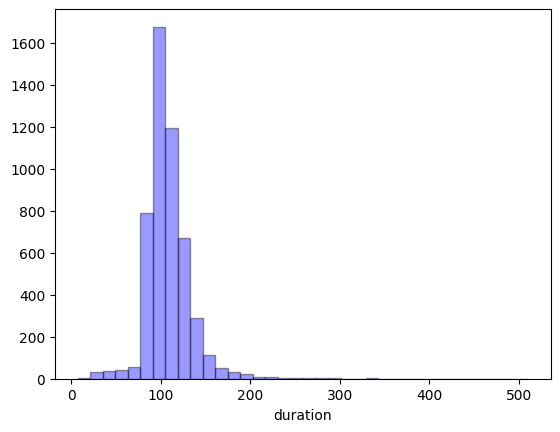

In [661]:
sns.distplot(data['duration'], hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [662]:
data.loc[data["duration"] >= 210,:].sort_values("duration",ascending=False)

,movie_title,title_year,color,aspect_ratio,duration,language,country,duration.1,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
1710,Trapped,NaN,Color,16.00,511.0,Icelandic,Iceland,511.0,Crime|Drama|Thriller,NaN,coastal town|iceland|police|snowstorm|winter s...,NaN,Ólafur Darri Ólafsson,Ingvar Eggert Sigurðsson,Björn Hlynur Haraldsson,307,NaN,8.2,NaN
2466,Carlos,NaN,Color,2.35,334.0,English,France,334.0,Biography|Crime|Drama|Thriller,Not Rated,opec|pubic hair|revolutionary|terrorism|true c...,NaN,Edgar Ramírez,Nora von Waldstätten,Katharina Schüttler,1032,NaN,7.7,145118.0
1501,"Blood In, Blood Out",1993.0,Color,1.66,330.0,English,USA,330.0,Crime|Drama,R,1970s|1980s|barrio|gang war|mexican,Taylor Hackford,Delroy Lindo,Jesse Borrego,Raymond Cruz,3227,35000000.0,8.0,4496583.0
1144,Heaven's Gate,1980.0,Color,2.35,325.0,English,USA,325.0,Adventure|Drama|Western,R,1890s|hired gun|immigrant|johnson county war|s...,Michael Cimino,Jeff Bridges,Sam Waterston,Isabelle Huppert,14255,44000000.0,6.8,1500000.0
3311,The Legend of Suriyothai,2001.0,Color,1.85,300.0,Thai,Thailand,300.0,Action|Adventure|Drama|History|War,R,16th century|burmese|invasion|queen|thailand,Chatrichalerm Yukol,Sarunyu Wongkrachang,Chatchai Plengpanich,Mai Charoenpura,32,400000000.0,6.6,454255.0
2970,Das Boot,1981.0,Color,1.85,293.0,German,West Germany,293.0,Adventure|Drama|Thriller|War,R,duty|submarine|submarine movie|tension|u boat,Wolfgang Petersen,Jürgen Prochnow,Martin Semmelrogge,Herbert Grönemeyer,469,14000000.0,8.4,11433134.0
1571,Apocalypse Now,1979.0,Color,2.35,289.0,English,USA,289.0,Drama|War,R,army|green beret|insanity|jungle|vietnam,Francis Ford Coppola,Harrison Ford,Marlon Brando,Robert Duvall,25313,31500000.0,8.5,78800000.0
2727,The Company,NaN,Color,1.78,286.0,English,USA,286.0,Drama|History|Thriller,NaN,cia|mole|revolution|spy|ussr,NaN,Anna Silk,Tom Hollander,Alessandro Nivola,3809,NaN,7.9,NaN
883,Gods and Generals,2003.0,Color,2.35,280.0,English,USA,280.0,Drama|History|War,PG-13,confederacy|hero|prequel|stonewall jackson|war...,Ron Maxwell,Billy Campbell,Bruce Boxleitner,John Castle,1671,56000000.0,6.3,12870569.0
1980,Gettysburg,1993.0,Color,1.85,271.0,English,USA,271.0,Drama|History|War,PG,american civil war|battle|blood splatter|civil...,Ron Maxwell,Tom Berenger,William Morgan Sheppard,James Patrick Stuart,2107,25000000.0,7.7,10769960.0


Vemos que hay, a priori, ya que luego trataremos de gestionar los outliers, supuestas películas con duraciones muy altas, que en algunas ocasiones resultan no ser películas si no series o miniseries; de un modo similar, hay películas con una duración tan baja (valor mínimo de 7 minutos) que imaginamos que serán cortometrajes.

Por ello, vamos a comprobar cuantas supuestas películas tenemos con una duración menor de 30 minutos o superior de 3 horas y 30 minutos y las eliminaremos de nuestro data set.

In [663]:
len(data[(data["duration"] > 210) | (data["duration"] < 30)])

51

In [664]:
mask = (data["duration"] > 210) | (data["duration"] < 30)
print(len(data))
data.drop(data[mask].index, inplace=True)
print(len(data))

5043
4992


### Análisis y procesamiento de variable language

Vamos a comprobar la representación de los diferentes idiomas en la variable language, ya que puede resultar una variable interesante a incluir en el modelo, pero puede ser que haya categorías infrarepresentadas que debamos juntar

In [665]:
data["language"].value_counts()

English       4659
French          73
Spanish         40
Hindi           28
Mandarin        26
German          18
Japanese        17
Italian         11
Russian         11
Cantonese       11
Portuguese       8
Korean           8
Danish           5
Hebrew           5
Arabic           5
Swedish          4
Norwegian        4
Persian          4
Polish           4
Dutch            4
Chinese          3
Zulu             2
Dari             2
Thai             2
None             2
Aboriginal       2
Romanian         2
Indonesian       2
Greek            1
Slovenian        1
Urdu             1
Vietnamese       1
Dzongkha         1
Tamil            1
Panjabi          1
Czech            1
Kannada          1
Mongolian        1
Filipino         1
Maya             1
Kazakh           1
Icelandic        1
Telugu           1
Hungarian        1
Bosnian          1
Aramaic          1
Swahili          1
Name: language, dtype: int64

Al seguir teniendo prácticamente un 93% de presencia la categoría English, podemos prácticamente imaginar que no va a ser una variable con demasiado valor explicativo.

Sin embargo, vamos a tratar de incluirla en el modelo, y luego volveremos a este punto para aclarar que resultado hemos obtenido y decidir si seguir incluyéndola o no.

In [666]:
min_lan = []

for l,v in data["language"].value_counts().items():
  if v < 100:
    min_lan.append(l)

Haremos los reemplazos necesarios y, ya que nos vamos a quedar con una variable dicotómica, directamente la vamos a sustituir por 1 y 0 para ahorrarnos el paso de dummyficarlas.

In [667]:
data["language"].replace("English",0,inplace=True)
data["language"].replace(min_lan,1,inplace=True)

data["language"].value_counts()

0.0    4659
1.0     322
Name: language, dtype: int64

Cuando se incluye la variable language recategorizada de esta manera, el modelo mejora muy muy ligeramente (pasando de un accuracy de 0.941176 a un 0.941860).

Aunque se trata de una variable dicotómica y con muy poco coste de recogida debido a la simplificidad de la misma, es un pequeño aporte que de momento no cosideraremos meter en el modelo. Sin embargo, se trata de una decisión relativamente trivial en este caso, por lo que podría ser incluida sin ningún problema en el caso de buscar incluir esa mejora, por infima que sea.

### Análisis y procesamiento de variable country

Vamos a realizar el mismo proceso que realizamos con language pero con Country, aunque imaginamos que la situación será similar, ya que se trata de dos variables muy relacionadas

In [668]:
data["country"].value_counts()

USA                     3772
UK                       441
France                   153
Canada                   126
Germany                   97
Australia                 55
India                     34
Spain                     33
China                     29
Japan                     22
Italy                     22
Mexico                    17
Hong Kong                 17
New Zealand               15
South Korea               14
Ireland                   12
Russia                    11
Denmark                   11
Brazil                     8
South Africa               8
Norway                     8
Netherlands                5
Sweden                     5
Poland                     5
Argentina                  4
Israel                     4
Iran                       4
Thailand                   4
Belgium                    4
Romania                    4
Czech Republic             3
Switzerland                3
Hungary                    2
Greece                     2
Taiwan        

Efectivamente, vemos que USA  recoge, en este caso, un 75% de las observaciones, y que por tanto, seguramente nos encontremos con un escenario similar al de language.

Sin embargo, hagamos la prueba, igual igual que antes.

In [669]:
min_con = []

for l,v in data["country"].value_counts().items():
  if v < 300:
    min_con.append(l)

data["country"].replace(min_con,"Otros",inplace=True)

data["country"].value_counts()

USA      3772
Otros     775
UK        441
Name: country, dtype: int64

Como sospechábamos, nos encontramos ante una situación parecida a la anterior (en este caso pasando de un accuracy de 0.941176 a 0.941655). Por ello, la decisión tomada será la misma.

### Separación de valores de género

A continuación, otra de las preparaciones que llevaremos a cabo en nuestros datos será la separación de los valores de género, de momento, en una lista.

Como están unidos en una sola string pero diferenciados por un separador "|", utilizaremos el método split para separar los valores


In [670]:
data["genres"] = data["genres"].apply(lambda x: x.split("|"))
data["genres"].head(3)

0    [Action, Adventure, Fantasy, Sci-Fi]
1            [Action, Adventure, Fantasy]
2           [Action, Adventure, Thriller]
Name: genres, dtype: object

### Separación de valores de plot_keywords

Repitamos el mismo proceso anterior pero para la variable keywords

In [671]:
data["plot_keywords"] = data["plot_keywords"].astype(str)
data["plot_keywords"] = data["plot_keywords"].apply(lambda x: x.split("|"))
data["plot_keywords"].head(3)

0         [avatar, future, marine, native, paraplegic]
1    [goddess, marriage ceremony, marriage proposal...
2            [bomb, espionage, sequel, spy, terrorist]
Name: plot_keywords, dtype: object

### Eliminación de la variable duration_l

Eliminaremos la variable duration_l por ser duplicada a la variable duration

In [672]:
data.drop("duration.1", axis=1, inplace=True)
data.head()

,movie_title,title_year,color,aspect_ratio,duration,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
0,Avatar,2009.0,Color,1.78,178.0,0.0,USA,"[Action, Adventure, Fantasy, Sci-Fi]",PG-13,"[avatar, future, marine, native, paraplegic]",James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834,237000000.0,7.9,760505847.0
1,Pirates of the Caribbean: At World's End,2007.0,Color,2.35,169.0,0.0,USA,"[Action, Adventure, Fantasy]",PG-13,"[goddess, marriage ceremony, marriage proposal...",Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48350,300000000.0,7.1,309404152.0
2,Spectre,2015.0,Color,2.35,148.0,0.0,UK,"[Action, Adventure, Thriller]",PG-13,"[bomb, espionage, sequel, spy, terrorist]",Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11700,245000000.0,6.8,200074175.0
3,The Dark Knight Rises,2012.0,Color,2.35,164.0,0.0,USA,"[Action, Thriller]",PG-13,"[deception, imprisonment, lawlessness, police ...",Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759,250000000.0,8.5,448130642.0
4,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,NaN,NaN,NaN,NaN,[Documentary],NaN,[nan],Doug Walker,Doug Walker,Rob Walker,NaN,143,NaN,7.1,NaN


## Preparación de la variable reparto

Vamos a eliminar los espacios de las variable referidas al reparto y aunarlas en una sola, a fin de posteriormente vectorizarlas. Esta decisión se toma de esta manera por la cantidad de valores únicos en estas variables.

In [673]:
reparto = ["actor_1_name","actor_2_name","actor_3_name"]

In [674]:
ind_a1n = []

for v,i in enumerate(data["actor_1_name"]):
  if type(i) == float:
    ind_a1n.append(v)

data.iloc[ind_a1n,:]

,movie_title,title_year,color,aspect_ratio,duration,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
4502,"Pink Ribbons, Inc.",2011.0,Color,NaN,97.0,0.0,Otros,[Documentary],Not Rated,"[breast cancer, comma in title, period in titl...",Léa Pool,NaN,NaN,NaN,0,1200000.0,7.4,24784.0
4519,Sex with Strangers,2002.0,Color,1.33,105.0,0.0,USA,"[Documentary, Drama]",NaN,"[bisexual, explicit sex, sex, stranger, swing]",Harry Gantz,NaN,NaN,NaN,0,NaN,4.7,247740.0
4720,The Harvest/La Cosecha,2011.0,Color,NaN,80.0,0.0,USA,[Documentary],NaN,"[child labor, education, hispanic, labor, migr...",U. Roberto Romano,NaN,NaN,NaN,0,560000.0,7.2,2245.0
4837,Ayurveda: Art of Being,2001.0,Color,1.85,102.0,0.0,Otros,[Documentary],NaN,"[eastern philosophy, healing, india, life]",Pan Nalin,NaN,NaN,NaN,0,300000.0,7.6,16892.0
4945,The Brain That Sings,2013.0,Color,NaN,62.0,1.0,Otros,"[Documentary, Family]",NaN,"[autism, middle east, music therapy, united ar...",Amal Al-Agroobi,NaN,NaN,NaN,0,125000.0,8.2,NaN
4946,The Blood of My Brother,2005.0,Color,1.66,90.0,0.0,USA,"[Documentary, War]",NaN,"[american, blood, dream, patrol, tank]",Andrew Berends,NaN,NaN,NaN,0,120000.0,6.6,NaN
4990,Counting,2015.0,Color,1.78,111.0,0.0,USA,[Documentary],NaN,"[city, city symphony, diary, essay, surveillance]",Jem Cohen,NaN,NaN,NaN,0,50000.0,6.0,NaN


In [675]:
mask = type(data.actor_1_name) == float

Primero comenzaremos eliminando los espacios

In [676]:
#for i in reparto:
#  data[i].apply(lambda x: x.replace(" ",""))

#data[reparto].head(2)

No permite hacer estas transformaciones porque aún existen valores NA en estas variables!! Lo mismo pasaría con las vectorizaciones, sin embargo, en el caso de los géneros no nos ha dado ningún problema debido a que desde un principio no había valores perdidos.

De modo que este tipo de transformaciones y vectorizaciones debieramos hacerlas después de la gestion de missings.

## Vectorización de la lista de géneros

Vamos a vectorizar por TfIdf para poder incluir los diferentes géneros en formato numérico

In [677]:
data["clean_genres"] = data["genres"].apply(lambda x: " ".join(x))

In [678]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizador = TfidfVectorizer()

generos_vector = vectorizador.fit_transform(data["clean_genres"])

**Uniremos este vector a nuestros datos después de haber depurado todos nuestros datos y antes de que vayamos generar las matrices de entrenamiento y de test**

# Gestión de valores indeseados (outliers y missings)

A continuación, vamos a comprobar como se encuentra nuestro dataset en cuanto a valores atípicos y outliers. A la vez que realizamos la comprobación de la existencia y relevancia de los mismos, tomaremos decisiones en cuanto a su gestión.

Antes de nada, separaremos nuestro dataset entre las potenciales variables predictoras y las potenciales variables objetivo, a fin de no modificar en la gestión de outliers y de valores perdidos ningún valor perteneciente a las variables objetivo (que son tomadas como verdad absoluta y no deben ser modificables o la generalización de nuestro modelo puede verse afetado por ello)

In [679]:
varObjIMDB = data["imdb_score"]
varObjGross = data["gross"]
imput = data.drop(["imdb_score","gross"],axis=1)

## Gestion de outliers

Comenzaremos trayendo de vuelta a este notebook una función que nos ayude a comprobar y a gestionar los outliers de nuestro dataset

In [680]:
## Función manual de winsor con clip+quantile
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array,
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'),
                  upper=s.quantile(1-limits[1], interpolation='higher'))

## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):

     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/col.mad())>8

     # Calcular primer cuartil
     q1 = col.quantile(0.25)
     # Calcular tercer cuartil
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

In [681]:
imput.select_dtypes(include=np.number).apply(lambda x: gestiona_outliers(x))

title_year
aspect_ratio
duration
language
cast_total_facebook_likes
budget


<ipython-input-680-8c31e4e00877>:21: FutureWarning:

The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.

<ipython-input-680-8c31e4e00877>:21: FutureWarning:

The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.

<ipython-input-680-8c31e4e00877>:21: FutureWarning:

The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.

<ipython-input-680-8c31e4e00877>:21: FutureWarning:

The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.

<ipython-input-680-8c31e4e00877>:21: FutureWarning:

The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.



,title_year,aspect_ratio,duration,language,cast_total_facebook_likes,budget
0,0.326131,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.89955,0.321479,6.464565,0.420673,0.265369
2,0.326131,0.89955,0.321479,6.464565,0.420673,0.265369


De momento, debida la poca incidencia de valores atípicos, no aplicaremos ningún tratamiento.

Más adelante, podríamos tratar de comprobar el efecto de diferentes gestiones a fin de ver que tipo de gestión (o la no gestión) mejora los resultados de nuestros modelos.

## Gestión de valores perdidos

Valores perdidos por observación

Primero de todo y antes de empezar a visualizar incidencia de valores perdidos, vamos a generar la típica variable prop_missings para tener un método de comprobación de que porcentaje de valores missings se recogen para cada registro

In [682]:
#Proporción de missings por observación (como una nueva columna del dataset)
imput['prop_missings'] = imput.apply(lambda x: x.isna().sum()/x.count()*100,axis=1)

# Valoramos distribución
imput.prop_missings.describe()

count    4992.000000
mean        1.841968
std         5.475198
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       112.500000
Name: prop_missings, dtype: float64

In [683]:
imput.sort_values("prop_missings", ascending=False).head(5)

,movie_title,title_year,color,aspect_ratio,duration,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,clean_genres,prop_missings
4,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,NaN,NaN,NaN,NaN,[Documentary],NaN,[nan],Doug Walker,Doug Walker,Rob Walker,NaN,143,NaN,Documentary,112.500000
2459,Unforgettable,NaN,NaN,NaN,60.0,NaN,USA,"[Drama, Mystery]",NaN,"[hyperthymesia, new york city, police]",NaN,Poppy Montgomery,Dylan Walsh,Dallas Roberts,1906,NaN,Drama Mystery,70.000000
2143,The Bachelor,NaN,Color,NaN,60.0,0.0,USA,"[Game-Show, Reality-TV, Romance]",NaN,"[bachelor, seeking love, single guy, tv host, ...",NaN,Chris Harrison,NaN,NaN,98,3000000.0,Game-Show Reality-TV Romance,54.545455
4015,The Secret,NaN,Color,NaN,45.0,0.0,UK,"[Drama, Thriller]",NaN,"[adultery, baptist church, dentist, double mur...",NaN,James Nesbitt,Ash Cook,Genevieve O'Reilly,1393,NaN,Drama Thriller,41.666667
4945,The Brain That Sings,2013.0,Color,NaN,62.0,1.0,Otros,"[Documentary, Family]",NaN,"[autism, middle east, music therapy, united ar...",Amal Al-Agroobi,NaN,NaN,NaN,0,125000.0,Documentary Family,41.666667


Vemos que hay muchas películas con una cantidad considerable de valores perdidos. En estos casos, cuando imputemos esos valores perdidos, nos vamos a encontrar con el problema de estar inventándonos un porcentaje muy alto de la información relativa a dichas películas.

Valores perdidos por variable

Comprobaremos también la presencia de valores missings en cada variable

In [684]:
imput.apply(lambda x: x.isna().sum()/x.count()*100)

movie_title                   0.000000
title_year                    1.752956
color                         0.361882
aspect_ratio                  6.917970
duration                      0.301386
language                      0.220839
country                       0.080192
genres                        0.000000
content_rating                6.235369
plot_keywords                 0.000000
director_name                 1.690772
actor_1_name                  0.140421
actor_2_name                  0.220839
actor_3_name                  0.422450
cast_total_facebook_likes     0.000000
budget                       10.393631
clean_genres                  0.000000
prop_missings                 0.000000
dtype: float64

Podemo comprobar que la variable con un porcentaje más peligroso de missings es la variable budget, que presenta un 10% de datos faltantes. Las demás variables presentan un porcentaje relativamente bajo de datos faltantes, pudiendo destacar como mucho la variable aspect_ratio con un 6.5% y content_ratio con un 5.8%

Imputaremos los valores faltantes usando el imputador por aleatoriedad, debida la diferente naturaleza de las variables.

Es un método aplicado por facilidad de uso, pero puede comprobarse más adelante como afectaría en los resultados del modelo la imputación po rotros modelos más avanzados.

In [685]:
!pip install feature_engine

import feature_engine.imputation as fe_imp
# Aleatoria: numéricas y nominales
imputer_rand = fe_imp.RandomSampleImputer()

In [686]:
imput_rand_imputed = imputer_rand.fit(imput).transform(imput)
imput_rand_imputed.describe()

,title_year,aspect_ratio,duration,language,cast_total_facebook_likes,budget,prop_missings
count,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4.992000e+03,4992.000000
mean,2002.583934,2.217871,106.693910,0.064503,9737.134415,3.982357e+07,1.841968
std,12.340693,1.360958,21.188993,0.245672,18216.828916,1.994344e+08,5.475198
min,1916.000000,1.180000,30.000000,0.000000,0.000000,2.180000e+02,0.000000
25%,1999.000000,1.850000,93.000000,0.000000,1420.250000,6.000000e+06,0.000000
50%,2005.000000,2.350000,103.000000,0.000000,3111.000000,2.000000e+07,0.000000
75%,2011.000000,2.350000,118.000000,0.000000,13809.500000,4.500000e+07,0.000000
max,2016.000000,16.000000,206.000000,1.000000,656730.000000,1.221550e+10,112.500000


In [687]:
imput_rand_imputed.head()

,movie_title,title_year,color,aspect_ratio,duration,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,clean_genres,prop_missings
0,Avatar,2009.0,Color,1.78,178.0,0.0,USA,"[Action, Adventure, Fantasy, Sci-Fi]",PG-13,"[avatar, future, marine, native, paraplegic]",James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834,237000000.0,Action Adventure Fantasy Sci-Fi,0.0
1,Pirates of the Caribbean: At World's End,2007.0,Color,2.35,169.0,0.0,USA,"[Action, Adventure, Fantasy]",PG-13,"[goddess, marriage ceremony, marriage proposal...",Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48350,300000000.0,Action Adventure Fantasy,0.0
2,Spectre,2015.0,Color,2.35,148.0,0.0,UK,"[Action, Adventure, Thriller]",PG-13,"[bomb, espionage, sequel, spy, terrorist]",Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11700,245000000.0,Action Adventure Thriller,0.0
3,The Dark Knight Rises,2012.0,Color,2.35,164.0,0.0,USA,"[Action, Thriller]",PG-13,"[deception, imprisonment, lawlessness, police ...",Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759,250000000.0,Action Thriller,0.0
4,Star Wars: Episode VII - The Force Awakens ...,2010.0,Color,2.35,131.0,0.0,USA,[Documentary],R,[nan],Doug Walker,Doug Walker,Rob Walker,Corbin Bleu,143,15000000.0,Documentary,112.5


Comprobemos si todos los missings han sido imputados

In [688]:
imput_rand_imputed.apply(lambda x: x.isna().sum()/x.count()*100)

movie_title                  0.0
title_year                   0.0
color                        0.0
aspect_ratio                 0.0
duration                     0.0
language                     0.0
country                      0.0
genres                       0.0
content_rating               0.0
plot_keywords                0.0
director_name                0.0
actor_1_name                 0.0
actor_2_name                 0.0
actor_3_name                 0.0
cast_total_facebook_likes    0.0
budget                       0.0
clean_genres                 0.0
prop_missings                0.0
dtype: float64

In [689]:
ind_a1n = []

for v,i in enumerate(imput_rand_imputed["actor_1_name"]):
  if type(i) == float:
    ind_a1n.append(v)

data.iloc[ind_a1n,:]

,movie_title,title_year,color,aspect_ratio,duration,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross,clean_genres


### Efectos a priori sobre la variable objetivo

Vamos a generar una función que nos permita comprobar de un primer vistazo que variables parecen tener una mayor relación con nuestra variable objetivo, que en nuestro caso, por tener todos los valores y por tanto estar completa, será, de momento, la variable imdb_score

Antes de realizar dicha comprobación, vamos a generar dos variables aleatorias que incluiremos en la función a fin de ayudarnos a comparar que variables están teniendo un efecto realmente significativo y diferente al que se da por mero azar

In [690]:
imput_rand_imputed['aleatorio'] = np.random.uniform(0,1,size=imput_rand_imputed.shape[0])
imput_rand_imputed['aleatorio2'] = np.random.uniform(0,1,size=imput_rand_imputed.shape[0])

In [691]:
datos = imput_rand_imputed.merge(varObjIMDB, how="left", left_index=True, right_index=True)

A continuación generaremos la función que compare la relación de cada variable con la variable objetivo, mediante el estadístico v de cramer

In [692]:
import scipy.stats as stats

def cramers_v(var1, varObj):

    if var1.dtypes == np.number:
      var1 = pd.cut(var1, bins = 5)
    if all([var1.value_counts().keys().size >= 100, var1.dtypes != np.number]):
      var1 = pd.cut(var1, bins = 5)

    data = pd.crosstab(var1, varObj).values
    vCramer = stats.contingency.association(data, method = 'cramer')
    return vCramer

In [693]:
tablaCramer = pd.DataFrame(imput_rand_imputed.select_dtypes(include=np.number).apply(lambda x: cramers_v(x, varObjIMDB)),columns=['VCramer']);

<ipython-input-692-8837b0a6c4d9>:5: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

<ipython-input-692-8837b0a6c4d9>:5: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

<ipython-input-692-8837b0a6c4d9>:5: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

<ipython-input-692-8837b0a6c4d9>:5: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

<ipython-input-692-8837b0a6c4d9>:5: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

<ipython-input-692-8837b0a6c4d9>:7: DeprecationWarning:

Con

In [694]:
import plotly.express as px
px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a IMDB').update_yaxes(categoryorder="total ascending")

In [695]:
cramers_v(imput_rand_imputed["duration"],varObjIMDB)

<ipython-input-692-8837b0a6c4d9>:5: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



0.2753317513512068

In [696]:
cramers_v(imput_rand_imputed["cast_total_facebook_likes"],varObjIMDB)

<ipython-input-692-8837b0a6c4d9>:5: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

<ipython-input-692-8837b0a6c4d9>:7: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



0.2034138137166463

Este error puede deberse a que hay alguna película cuyo valor este siendo considerado como entero o float, o que haya algún otro valor mal considerado en alguna variable supuestamente de string, y que por tanto no se esté agrupando como debería

# Entrenamiento de modelos

Últimos procesamientos en los datos y entrenamiento de modelo, habiendo jugado con las variables que incluímos. Los algoritmos escogidos para las pruebas son RandomForest y XGBoost.


## Procesamiento de los datos y puesta en marcha de los primeros modelos

Primero de todo, vamos a empezar transformando los datos de texto en vectores, tal y como pudimos hacer previamente con los generos pero no con el resto de variables

De cara a trabajar con las keywords, vamos a probar a stemizar estas palabras, con el fin de comprobar si nuestro modelo trabajará mejor con este preprocesado en dicha variable

In [697]:
# Stemming
import string
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
def stem(tokens):
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens

In [698]:
imput_rand_imputed["clean_plotkey"] = imput_rand_imputed["plot_keywords"].apply(lambda x: stem(x))
imput_rand_imputed["clean_plotkey"] = imput_rand_imputed["clean_plotkey"].apply(lambda x: " ".join(x))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizador = TfidfVectorizer()

plotkey_vector = vectorizador.fit_transform(imput_rand_imputed["clean_plotkey"])

El el caso de los datos relativos al reparto, no tiene sentido stemizar los diferentes actores ya que son personas individuales y que no tienen porque tener nada que ver la una con la otra aunque compartan el mismo nombre o apellido

In [699]:
imput_rand_imputed["actor_1_name"] = imput_rand_imputed["actor_1_name"].apply(lambda x: "".join(x.split()))
imput_rand_imputed["actor_2_name"] = imput_rand_imputed["actor_2_name"].apply(lambda x: "".join(x.split()))
imput_rand_imputed["actor_3_name"] = imput_rand_imputed["actor_3_name"].apply(lambda x: "".join(x.split()))

imput_rand_imputed["reparto"] = imput_rand_imputed["actor_1_name"] + " " + imput_rand_imputed["actor_2_name"] + " " + imput_rand_imputed["actor_3_name"]

vectorizador_rep = TfidfVectorizer()

reparto_vector = vectorizador_rep.fit_transform(imput_rand_imputed["reparto"])

## Prueba de OneHotEncoders para la variable country

Vamos a hacer una pequeña prueba con OneHotEncoder para convertir en dummys la variable country que recogerá los valores USA, UK y Otros; solamente para ver como afecta al modelo, aunque lo más seguro es que no lo haga de manera muy relevante.

In [700]:
#from sklearn.preprocessing import OneHotEncoder

#ct = OneHotEncoder(handle_unknown='ignore')

#country = ct.fit_transform(np.array(imput_rand_imputed["country"]).reshape(-1,1))

De hecho, acaba empeorando el modelo (Pasando de 0.941176 a 0.939961), por lo que, se queda en prototipo y no lo incluirémos.

## Preparación y partición de los datos

In [701]:
import numpy as np

#y = varObjIMDB.values.astype(np.float32)

#print(y.shape)

Vamos a probar un asunto: Dado que parece que me esté dando problemas de procesado el tema de que los modelos sean de regresión, vamos a tratar de categorizar las variables en puntuaciones menores que 0.25, menores que 0.5, menores que 0.75 y mayores que 0.75

In [702]:
y = pd.cut(varObjIMDB, [0, 2.499, 4.99, 7.499, 10], labels=[0,1,2,3])

In [703]:
extra_features = imput_rand_imputed[["duration"]]

import scipy as sp

X = sp.sparse.hstack((generos_vector,reparto_vector,plotkey_vector,extra_features.values),format='csr')

In [704]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(3744, 12648)
(1248, 12648)


## Entrenamiento de modelos de Random Forest

In [705]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

pd.crosstab(y_pred,y_test)

imdb_score,0,1,2,3
row_0,,,,
1,0,2,1,0
2,2,132,907,182
3,0,0,2,20


In [706]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

0.7443910256410257

Parece a priori que no tiene una mala aproximación, sin embargo, contamos con datos muy desbalanceados, lo cual tocaría arreglar

In [707]:
y.value_counts(normalize=True)

2    0.732171
3    0.171274
1    0.092949
0    0.003606
Name: imdb_score, dtype: float64

In [708]:
# Vamos a probar como mejoraría el rendimiento del modelo en el caso de balancear los datos que
# pertenecen a la categoría peor representada.

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2,sampling_strategy='not majority')
X_res, y_res = sm.fit_resample(X, y)

In [709]:
y_res.value_counts(normalize=True)

0    0.25
1    0.25
2    0.25
3    0.25
Name: imdb_score, dtype: float64

In [710]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state=0)
print(X_train_res.shape)
print(X_test_res.shape)

(10965, 12648)
(3655, 12648)


In [711]:
model_res = RandomForestClassifier(n_estimators=100, random_state=0)

model_res.fit(X_train_res, y_train_res)
y_pred = model_res.predict(X_test)

pd.crosstab(y_pred,y_test)

imdb_score,0,1,2,3
row_0,,,,
0,2,0,0,0
1,0,125,0,0
2,0,9,909,21
3,0,0,1,181


In [712]:
accuracy_score(y_test,y_pred)

0.9751602564102564

Veo que con mis datos balanceados obtengo unos resultados muchísimo mejores, llegando a un punto en el que difícilmente podremos esperar encontrar unos datos tan buenos

Por sospechas, probemos a evaluar este último modelo utilizando técnicas de validación cruzada

In [713]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(estimator=model_res, X=X_res, y=y_res, cv=5)
results.mean()

0.9533515731874145

In [714]:
results = cross_val_score(estimator=model, X=X, y=y, cv=5)
results.mean()

0.7407854748536111

Definitivamente, el modelo con los datos balanceados resulta un modelo mucho más potente que el entrenado con los datos desbalanceados

## Entrenamiento de modelo XgBoost

Vamos a hacer pruebas y a entrenar modelos bajo algoritmos de boosting a fin de comprobar si mejoran o empeoran el rendimeinto de los modelos anteriores

In [715]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(seed=0)

model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)

pd.crosstab(y_pred,y_test)

imdb_score,0,1,2,3
row_0,,,,
1,0,12,7,1
2,2,122,861,156
3,0,0,42,45


In [716]:
accuracy_score(y_test,y_pred)

0.7355769230769231

Con los datos sin balancear mejora ligeramente, pero veamos como se comporta con los datos balanceados

In [717]:
model_xgb_res = XGBClassifier(seed=0)

model_xgb_res.fit(X_train_res,y_train_res)
y_pred = model_xgb_res.predict(X_test)

pd.crosstab(y_pred,y_test)

imdb_score,0,1,2,3
row_0,,,,
0,2,0,1,0
1,0,59,10,1
2,0,74,868,89
3,0,1,31,112


In [718]:
accuracy_score(y_test,y_pred)

0.8341346153846154

En este caso, parece que las predicciones empeoran con respecto al RandomForest con datos balanceados, sin embargo, un accuracy de 0.84 es mucho más seguro y menos sospechoso que un accuracy de casi 0.95

Veamos a ver que resultados sacamos de evaluar este último modelo por validación cruzada

In [719]:
results = cross_val_score(estimator=model_xgb_res, X=X_res, y=y_res, cv=5)
results.mean()

0.8802325581395349

Dado que no mejora los resultados obtenidos con el modelo entrenado bajo el algoritmo RandomForest con los mismos datos balanceados, de momento ese será el modelo final.